# WiFi Fingerprint Extraction from Manually Collected Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from glob import glob
from tqdm import tqdm

%matplotlib inline

In [3]:
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [4]:
from io_f import read_data_file

## Explore the Dataset

In [5]:
sites = list(glob("../../data/train/*"))

In [6]:
len(sites)

204

In [7]:
sites[0]

'../../data/train/5da138b74db8ce0c98bd4774'

In [8]:
list(glob(sites[0] + "/*"))

['../../data/train/5da138b74db8ce0c98bd4774/F5',
 '../../data/train/5da138b74db8ce0c98bd4774/F2',
 '../../data/train/5da138b74db8ce0c98bd4774/B2',
 '../../data/train/5da138b74db8ce0c98bd4774/F4',
 '../../data/train/5da138b74db8ce0c98bd4774/B1',
 '../../data/train/5da138b74db8ce0c98bd4774/F1',
 '../../data/train/5da138b74db8ce0c98bd4774/F3']

In [9]:
len(list(glob(sites[0] + "/F1/*")))

85

In [10]:
track_file_list = list(glob(sites[0] + "/F1/*"))

In [11]:
path_data = read_data_file(track_file_list[0])

In [12]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [13]:
waypoint_df = extract_waypoint_df(path_data.waypoint)

In [14]:
def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  return wifi_df

In [15]:
wifi_df = extract_wifi_df(path_data.wifi)

## Interpolate waypoints for WiFi fingerprints


In [16]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame, track_wifi_df: pd.DataFrame, max_offset_sec: int=2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts <= max_offset_sec)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1] <= max_offset_sec)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]
  
  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts - prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(
    np.vstack([wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]]).T, 
    columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [17]:
wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)

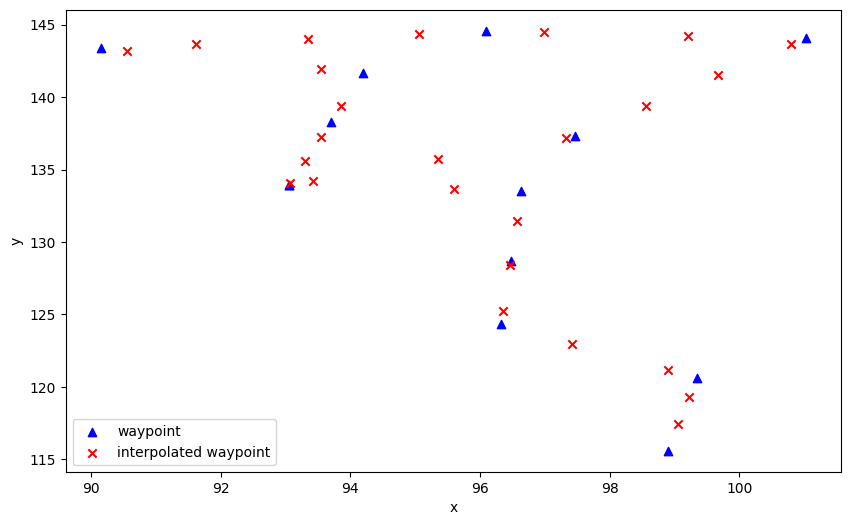

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(waypoint_df["x"].values, waypoint_df["y"].values, marker="^", color="blue", label="waypoint")
ax.scatter(wifi_waypoint_df["x"].values, wifi_waypoint_df["y"].values, marker="x", color="red", label="interpolated waypoint")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.show()

In [19]:
wifi_fingerprint_df = pd.merge(wifi_df, wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")

## Ground-truth Data Extraction Pipeline

In [20]:
input_dir = "../../data/train/"
output_dir = "../../data/wifi_fingerprint_manual/train/"

if not input_dir.endswith("/"):
  input_dir += "/"

if not output_dir.endswith("/"):
  output_dir += "/"

In [21]:
input_sites = list(glob(input_dir + "*"))

In [22]:
track_list = []

for site_path in input_sites:
  site_id = os.path.basename(site_path)
  
  input_floor_paths = glob(site_path + "/*")
  for input_floor_path in input_floor_paths:
    floor_id = os.path.basename(input_floor_path)

    # Track
    track_path_list = list(glob(input_floor_path + "/*"))
    track_list.extend([
      {
        "site_id": site_id,
        "floor_id": floor_id,
        "track_id": os.path.splitext(os.path.basename(track_path))[0],
        "track_path": track_path,
      }
      for track_path in track_path_list
    ])
    
track_list_df = pd.DataFrame(track_list)

In [23]:
print(f"The number of tracks is {len(track_list)}")

The number of tracks is 26925


In [24]:
%%time

failed_tracks = []

for track_spec in tqdm(track_list):
  output_path = output_dir + track_spec["site_id"] + "/" + track_spec["floor_id"]
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  try:
    # Read input
    path_data = read_data_file(track_spec["track_path"])

    # Extract and transform the datasets
    waypoint_df = extract_waypoint_df(path_data.waypoint)
    wifi_df = extract_wifi_df(path_data.wifi)
    wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)
    wifi_fingerprint_df = pd.merge(wifi_df, wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")

    # Save output
    waypoint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_waypoint.csv", index=False, header=True)
    wifi_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi.csv", index=False, header=True)
    wifi_fingerprint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi_fingerprint.csv", index=False, header=True)
  
  except Exception as e:
    failed_tracks.append(track_spec)
    print(f"[ERROR] Failed to process track located at {track_spec['track_path']}, caused by: {str(e)}")

  4%|▍         | 1145/26925 [02:34<59:04,  7.27it/s]  

[ERROR] Failed to process track located at ../../data/train/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb.txt, caused by: Empty data passed with indices specified.


  4%|▍         | 1149/26925 [02:35<56:06,  7.66it/s]  

[ERROR] Failed to process track located at ../../data/train/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93.txt, caused by: Empty data passed with indices specified.


 14%|█▍        | 3733/26925 [08:01<30:02, 12.87it/s]  

[ERROR] Failed to process track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfafc494e4900006125908.txt, caused by: Empty data passed with indices specified.


 14%|█▍        | 3771/26925 [08:05<30:56, 12.47it/s]

[ERROR] Failed to process track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfb02594e4900006125943.txt, caused by: Empty data passed with indices specified.


 14%|█▍        | 3824/26925 [08:09<36:52, 10.44it/s]

[ERROR] Failed to process track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfb01594e490000612593c.txt, caused by: Empty data passed with indices specified.


 16%|█▌        | 4229/26925 [08:49<42:27,  8.91it/s]  

[ERROR] Failed to process track located at ../../data/train/5dc8cea7659e181adb076a3f/F1/5dcf7852878f3300066c6d5e.txt, caused by: Empty data passed with indices specified.


 16%|█▌        | 4246/26925 [08:51<30:26, 12.42it/s]  

[ERROR] Failed to process track located at ../../data/train/5dc8cea7659e181adb076a3f/F3/5dccee18c04f060006e6e2e6.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5442/26925 [11:31<40:52,  8.76it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e09666dae83d4000603a5a4.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8a1274230006b33bef.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5449/26925 [11:33<1:09:41,  5.14it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8c1274230006b33bf1.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5450/26925 [11:33<1:03:25,  5.64it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966edbcbcf90006b9cb50.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5462/26925 [11:35<41:43,  8.57it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e08297fae83d4000603a385.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5466/26925 [11:35<42:58,  8.32it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082996bcbcf90006b9c927.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5470/26925 [11:37<1:21:59,  4.36it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e096652ae83d4000603a59c.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5478/26925 [11:37<42:10,  8.48it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966f0bcbcf90006b9cb52.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082999ae83d4000603a389.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5484/26925 [11:39<1:02:06,  5.75it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082990ae83d4000603a387.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5487/26925 [11:39<50:46,  7.04it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a842cadcb00060864d0.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5488/26925 [11:40<1:23:13,  4.29it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8d1274230006b33bf3.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966efae83d4000603a5ad.txt, caused by: Empty data passed with indices specified.


 20%|██        | 5498/26925 [11:41<54:54,  6.50it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a802cadcb00060864ce.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5604/26925 [12:04<43:12,  8.22it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8931274230006b33b00.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8991274230006b33b06.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e87d1274230006b33af9.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5610/26925 [12:04<37:29,  9.47it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9e01274230006b33b2d.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5628/26925 [12:07<36:30,  9.72it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8971274230006b33b04.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5637/26925 [12:08<33:35, 10.56it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12c0932cadcb0006086221.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea121274230006b33b41.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5645/26925 [12:08<23:51, 14.86it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a31274230006b33b0e.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8292cadcb000608618e.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8912cadcb00060863e1.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5649/26925 [12:09<39:52,  8.89it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12c0892cadcb000608621d.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5653/26925 [12:10<1:08:25,  5.18it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9eb1274230006b33b31.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a82d2cadcb0006086192.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8b41274230006b33b17.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5660/26925 [12:12<57:11,  6.20it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8321274230006b338ff.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5664/26925 [12:13<1:24:31,  4.19it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea1d2cadcb000608640f.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f71274230006b33b37.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5666/26925 [12:14<1:10:02,  5.06it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8882cadcb00060863db.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea002cadcb0006086409.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5672/26925 [12:15<1:12:41,  4.87it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e89b1274230006b33b08.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5677/26925 [12:15<49:20,  7.18it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e89f2cadcb00060863e5.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5681/26925 [12:16<48:01,  7.37it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8af1274230006b33b15.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9d61274230006b33b29.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5690/26925 [12:17<40:15,  8.79it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a11274230006b33b0c.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5695/26925 [12:18<1:01:26,  5.76it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8782cadcb00060863d7.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f01274230006b33b33.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea0c2cadcb000608640b.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5710/26925 [12:20<36:43,  9.63it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea181274230006b33b45.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8b71274230006b33b19.txt, caused by: Empty data passed with indices specified.


 21%|██        | 5717/26925 [12:21<42:00,  8.41it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a51274230006b33b11.txt, caused by: Empty data passed with indices specified.


 21%|██▏       | 5723/26925 [12:22<51:26,  6.87it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a82c1274230006b338fb.txt, caused by: Empty data passed with indices specified.


 21%|██▏       | 5724/26925 [12:22<1:09:06,  5.11it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f52cadcb0006086403.txt, caused by: Empty data passed with indices specified.


 21%|██▏       | 5729/26925 [12:23<48:53,  7.23it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8902cadcb00060863df.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8892cadcb00060863dd.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8301274230006b338fd.txt, caused by: Empty data passed with indices specified.


 21%|██▏       | 5733/26925 [12:23<40:45,  8.67it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9fb2cadcb0006086407.txt, caused by: Empty data passed with indices specified.


 21%|██▏       | 5735/26925 [12:24<1:00:49,  5.81it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9d21274230006b33b27.txt, caused by: Empty data passed with indices specified.


 29%|██▉       | 7780/26925 [17:51<54:23,  5.87it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56b83e2acfd2d33b5cab0/B2/5cf72539e9d9c9000852f45b.txt, caused by: list index out of range


 30%|██▉       | 7973/26925 [18:17<13:28, 23.44it/s]  

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc54bd921dceb0006114b4b.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc653101cda37000603043f.txt, caused by: Empty data passed with indices specified.


 30%|██▉       | 8005/26925 [18:18<14:28, 21.80it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc6530e1cda37000603043b.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc54bd81cda37000602fca4.txt, caused by: Empty data passed with indices specified.


 30%|██▉       | 8024/26925 [18:19<09:39, 32.62it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F4/5dc6987017ffdd0006f11974.txt, caused by: Empty data passed with indices specified.


 30%|██▉       | 8033/26925 [18:19<08:31, 36.91it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F4/5dc6986f1cda370006030a7b.txt, caused by: Empty data passed with indices specified.


 30%|███       | 8129/26925 [18:23<11:08, 28.11it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F4/5dc698691cda370006030a77.txt, caused by: Empty data passed with indices specified.


 31%|███       | 8337/26925 [18:32<19:26, 15.93it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F3/5dc682f41cda3700060308e2.txt, caused by: Empty data passed with indices specified.


 31%|███       | 8356/26925 [18:33<13:57, 22.17it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F3/5dc63f2817ffdd0006f111d7.txt, caused by: Empty data passed with indices specified.


 31%|███       | 8395/26925 [18:35<13:18, 23.20it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F3/5dc6479d1cda370006030330.txt, caused by: Empty data passed with indices specified.


 31%|███       | 8412/26925 [18:35<12:26, 24.79it/s]

[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F3/5dc682f91cda3700060308e8.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5da1389e4db8ce0c98bd0547/F3/5dc647af17ffdd0006f112bb.txt, caused by: Empty data passed with indices specified.


 47%|████▋     | 12735/26925 [27:19<32:15,  7.33it/s]  

[ERROR] Failed to process track located at ../../data/train/5dbc1d84c1eb61796cf7c010/F2/5dd37f0444333f00067aa24d.txt, caused by: Empty data passed with indices specified.


 50%|████▉     | 13384/26925 [28:40<33:02,  6.83it/s]  

[ERROR] Failed to process track located at ../../data/train/5dbc1d84c1eb61796cf7c010/F3/5dd3902827889b0006b76ae2.txt, caused by: Empty data passed with indices specified.


 55%|█████▍    | 14761/26925 [30:55<11:49, 17.15it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd969c339e2fc0b4afe7775/F3/5d0b53d27a560f00088a96e0.txt, caused by: Empty data passed with indices specified.


 57%|█████▋    | 15359/26925 [32:05<30:27,  6.33it/s]  

[ERROR] Failed to process track located at ../../data/train/5a0546857ecc773753327266/F3/5d8f0955b6e29d0006fb8c0f.txt, caused by: Empty data passed with indices specified.


 57%|█████▋    | 15364/26925 [32:05<21:51,  8.82it/s]

[ERROR] Failed to process track located at ../../data/train/5a0546857ecc773753327266/F3/5d8f0954b6e29d0006fb8c0d.txt, caused by: Empty data passed with indices specified.


 57%|█████▋    | 15400/26925 [32:09<19:26,  9.88it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56b5ae2acfd2d33b58549/5F/5d06134dfca4240009a5d39c.txt, caused by: Empty data passed with indices specified.


 57%|█████▋    | 15461/26925 [32:15<22:17,  8.57it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d0756d4b53a8d0008dd4ac9.txt, caused by: Empty data passed with indices specified.


 57%|█████▋    | 15473/26925 [32:17<24:38,  7.75it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d05ea9546c6c400085684e4.txt, caused by: Empty data passed with indices specified.


 58%|█████▊    | 15488/26925 [32:18<19:54,  9.58it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d0756d3761a1f00088a0b12.txt, caused by: Empty data passed with indices specified.


 58%|█████▊    | 15499/26925 [32:19<18:37, 10.22it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d05fc354a19c000086c400d.txt, caused by: Empty data passed with indices specified.


 58%|█████▊    | 15530/26925 [32:23<18:20, 10.35it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c03e2acfd2d33b69c1f/F5/5d0898955125450008037c9d.txt, caused by: Empty data passed with indices specified.


 58%|█████▊    | 15532/26925 [32:23<19:52,  9.55it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56c03e2acfd2d33b69c1f/F5/5d08989c3f461f0008dac489.txt, caused by: Empty data passed with indices specified.


 73%|███████▎  | 19611/26925 [42:28<12:20,  9.87it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56b6ae2acfd2d33b59ccb/F1/5df5d94e13d568000671a6fa.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22049/26925 [47:28<30:50,  2.63it/s]  

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d08807604c8c40008ab4b2a.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22053/26925 [47:28<23:10,  3.50it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716411b107f00081cf3ed.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22056/26925 [47:29<22:56,  3.54it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0720cf4a19c000086c5325.txt, caused by: Empty data passed with indices specified.
[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716491b107f00081cf3ef.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22061/26925 [47:31<18:17,  4.43it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716464a19c000086c5224.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22062/26925 [47:31<23:19,  3.48it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d08807504c8c40008ab4b28.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22064/26925 [47:32<28:01,  2.89it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d07390f1a69370008bc5c93.txt, caused by: Empty data passed with indices specified.


 82%|████████▏ | 22067/26925 [47:33<28:39,  2.82it/s]

[ERROR] Failed to process track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0739201a69370008bc5c96.txt, caused by: Empty data passed with indices specified.


 83%|████████▎ | 22444/26925 [48:13<03:38, 20.53it/s]

[ERROR] Failed to process track located at ../../data/train/5d2709d403f801723c32bd39/2F/5dc77d571cda370006030ef7.txt, caused by: Empty data passed with indices specified.


 84%|████████▎ | 22485/26925 [48:18<07:41,  9.63it/s]

[ERROR] Failed to process track located at ../../data/train/5d2709d403f801723c32bd39/2F/5dcd15b723759900063d5524.txt, caused by: Empty data passed with indices specified.


100%|██████████| 26925/26925 [58:37<00:00,  7.65it/s]

CPU times: user 55min 40s, sys: 1min 14s, total: 56min 55s
Wall time: 58min 37s


## Explore Failed Tracks

In [28]:
track_spec = failed_tracks[0]

In [34]:
non_empty_wifi_track = []

for track_spec in failed_tracks:
  try:
    path_data = read_data_file(track_spec["track_path"])
    if len(path_data.wifi) != 0:
      non_empty_wifi_track.append(track_spec)
  except Exception as e:
    print(f"Exception: {str(e)}")
    non_empty_wifi_track.append(track_spec)

Exception: list index out of range


In [33]:
non_empty_wifi_track

[{'site_id': '5cd56b83e2acfd2d33b5cab0',
  'floor_id': 'B2',
  'track_id': '5cf72539e9d9c9000852f45b',
  'track_path': '../../data/train/5cd56b83e2acfd2d33b5cab0/B2/5cf72539e9d9c9000852f45b.txt'}]

In [48]:
from dataclasses import dataclass

@dataclass
class ReadData:
  acce: np.ndarray
  acce_uncali: np.ndarray
  gyro: np.ndarray
  gyro_uncali: np.ndarray
  magn: np.ndarray
  magn_uncali: np.ndarray
  ahrs: np.ndarray
  wifi: np.ndarray
  ibeacon: np.ndarray
  waypoint: np.ndarray

def read_data_file(data_filename, enabled_types=None):
  acce = []
  acce_uncali = []
  gyro = []
  gyro_uncali = []
  magn = []
  magn_uncali = []
  ahrs = []
  wifi = []
  ibeacon = []
  waypoint = []

  with open(data_filename, 'r', encoding='utf-8') as file:
      lines = file.readlines()

  for line_data in lines:
    try:
      line_data = line_data.strip()
      if not line_data or line_data[0] == '#':
        continue

      line_data = line_data.split('\t')

      if line_data[1] == 'TYPE_ACCELEROMETER':
        acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
        acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_GYROSCOPE':
        gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
        gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_MAGNETIC_FIELD':
        magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
        magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_ROTATION_VECTOR':
        ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
        continue

      if line_data[1] == 'TYPE_WIFI':
        sys_ts = line_data[0]
        ssid = line_data[2]
        bssid = line_data[3]
        rssi = line_data[4]
        freq = line_data[5]
        lastseen_ts = line_data[6]
        wifi_data = [sys_ts, ssid, bssid, rssi, freq, lastseen_ts]
        wifi.append(wifi_data)
        continue

      if line_data[1] == 'TYPE_BEACON':
        ts = line_data[0]
        uuid = line_data[2]
        major = line_data[3]
        minor = line_data[4]
        rssi = line_data[6]
        ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
        ibeacon.append(ibeacon_data)
        continue

      if line_data[1] == 'TYPE_WAYPOINT':
        waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
    except Exception as e:
      print(f"Failed to processing line: {line_data}. Caused by {str(e)}")
    
  acce = np.array(acce)
  acce_uncali = np.array(acce_uncali)
  gyro = np.array(gyro)
  gyro_uncali = np.array(gyro_uncali)
  magn = np.array(magn)
  magn_uncali = np.array(magn_uncali)
  ahrs = np.array(ahrs)
  wifi = np.array(wifi)
  ibeacon = np.array(ibeacon)
  waypoint = np.array(waypoint)

  return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)


In [49]:
%%time

for track_spec in tqdm(failed_tracks):
  output_path = output_dir + track_spec["site_id"] + "/" + track_spec["floor_id"]
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  try:
    # Read input
    path_data = read_data_file(track_spec["track_path"])

    if len(path_data.wifi) == 0:
      print(f"No WiFi fingerprints found. Track located at {track_spec['track_path']}")
      continue

    # Extract and transform the datasets
    waypoint_df = extract_waypoint_df(path_data.waypoint)
    wifi_df = extract_wifi_df(path_data.wifi)
    wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)
    wifi_fingerprint_df = pd.merge(wifi_df, wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")

    # Save output
    waypoint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_waypoint.csv", index=False, header=True)
    wifi_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi.csv", index=False, header=True)
    wifi_fingerprint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi_fingerprint.csv", index=False, header=True)
  
  except Exception as e:
    failed_tracks.append(track_spec)
    print(f"[ERROR] Failed to process track located at {track_spec['track_path']}, caused by: {str(e)}")

  2%|▏         | 2/94 [00:00<00:14,  6.56it/s]

No WiFi fingerprints found. Track located at ../../data/train/5d27075f03f801723c2e360f/F2/5de0cd4fbbb32e0006603cdb.txt
No WiFi fingerprints found. Track located at ../../data/train/5d27075f03f801723c2e360f/F2/5de0a58bbbb32e0006603c93.txt
No WiFi fingerprints found. Track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfafc494e4900006125908.txt
No WiFi fingerprints found. Track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfb02594e4900006125943.txt
No WiFi fingerprints found. Track located at ../../data/train/5dc8cea7659e181adb076a3f/F2/5dcfb01594e490000612593c.txt


  9%|▊         | 8/94 [00:00<00:04, 20.36it/s]

No WiFi fingerprints found. Track located at ../../data/train/5dc8cea7659e181adb076a3f/F1/5dcf7852878f3300066c6d5e.txt
No WiFi fingerprints found. Track located at ../../data/train/5dc8cea7659e181adb076a3f/F3/5dccee18c04f060006e6e2e6.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e09666dae83d4000603a5a4.txt


 11%|█         | 10/94 [00:00<00:08, 10.25it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8a1274230006b33bef.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8c1274230006b33bf1.txt


 16%|█▌        | 15/94 [00:01<00:05, 13.45it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966edbcbcf90006b9cb50.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e08297fae83d4000603a385.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082996bcbcf90006b9c927.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e096652ae83d4000603a59c.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966f0bcbcf90006b9cb52.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082999ae83d4000603a389.txt


 18%|█▊        | 17/94 [00:01<00:08,  9.36it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e082990ae83d4000603a387.txt


 23%|██▎       | 22/94 [00:02<00:06, 10.89it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a842cadcb00060864d0.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a8d1274230006b33bf3.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e0966efae83d4000603a5ad.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/L1/5e130a802cadcb00060864ce.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8931274230006b33b00.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8991274230006b33b06.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e87d1274230006b33af9.txt


 29%|██▊       | 27/94 [00:02<00:04, 14.33it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9e01274230006b33b2d.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8971274230006b33b04.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12c0932cadcb0006086221.txt


 33%|███▎      | 31/94 [00:02<00:04, 14.12it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea121274230006b33b41.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a31274230006b33b0e.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8292cadcb000608618e.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8912cadcb00060863e1.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12c0892cadcb000608621d.txt


 37%|███▋      | 35/94 [00:03<00:04, 12.12it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9eb1274230006b33b31.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a82d2cadcb0006086192.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8b41274230006b33b17.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8321274230006b338ff.txt


 39%|███▉      | 37/94 [00:03<00:06,  8.84it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea1d2cadcb000608640f.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f71274230006b33b37.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8882cadcb00060863db.txt


 46%|████▌     | 43/94 [00:03<00:04, 12.04it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea002cadcb0006086409.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e89b1274230006b33b08.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e89f2cadcb00060863e5.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8af1274230006b33b15.txt


 51%|█████     | 48/94 [00:04<00:03, 14.65it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9d61274230006b33b29.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a11274230006b33b0c.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8782cadcb00060863d7.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f01274230006b33b33.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea0c2cadcb000608640b.txt


 53%|█████▎    | 50/94 [00:04<00:04, 10.90it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12ea181274230006b33b45.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8b71274230006b33b19.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8a51274230006b33b11.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a82c1274230006b338fb.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9f52cadcb0006086403.txt


 61%|██████    | 57/94 [00:04<00:02, 13.19it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8902cadcb00060863df.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e8892cadcb00060863dd.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12a8301274230006b338fd.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9fb2cadcb0006086407.txt


 77%|███████▋  | 72/94 [00:05<00:01, 21.91it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c18e2acfd2d33b6c321/B1/5e12e9d21274230006b33b27.txt
Failed to processing line: ['1559699299331', 'TYPE_ROTATION_VECTOR', '0.17401376', '-0.0031055238']. Caused by list index out of range
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc54bd921dceb0006114b4b.txt
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc653101cda37000603043f.txt
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc6530e1cda37000603043b.txt
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/B2/5dc54bd81cda37000602fca4.txt
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/F4/5dc6987017ffdd0006f11974.txt
No WiFi fingerprints found. Track located at ../../data/train/5da1389e4db8ce0c98bd0547/F4/5dc6986f1cda370006030a7b.txt
No WiFi fingerprints found. Trac

 83%|████████▎ | 78/94 [00:05<00:00, 25.66it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56b5ae2acfd2d33b58549/5F/5d06134dfca4240009a5d39c.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d0756d4b53a8d0008dd4ac9.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d05ea9546c6c400085684e4.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d0756d3761a1f00088a0b12.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56b5ae2acfd2d33b58549/1F/5d05fc354a19c000086c400d.txt


 88%|████████▊ | 83/94 [00:06<00:00, 18.52it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56c03e2acfd2d33b69c1f/F5/5d0898955125450008037c9d.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56c03e2acfd2d33b69c1f/F5/5d08989c3f461f0008dac489.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56b6ae2acfd2d33b59ccb/F1/5df5d94e13d568000671a6fa.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d08807604c8c40008ab4b2a.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716411b107f00081cf3ed.txt


 93%|█████████▎| 87/94 [00:07<00:00,  8.71it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0720cf4a19c000086c5325.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716491b107f00081cf3ef.txt


 96%|█████████▌| 90/94 [00:08<00:00,  7.56it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0716464a19c000086c5224.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d08807504c8c40008ab4b28.txt
No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d07390f1a69370008bc5c93.txt


100%|██████████| 94/94 [00:09<00:00, 10.01it/s]

No WiFi fingerprints found. Track located at ../../data/train/5cd56bc1e2acfd2d33b6404d/G/5d0739201a69370008bc5c96.txt
No WiFi fingerprints found. Track located at ../../data/train/5d2709d403f801723c32bd39/2F/5dc77d571cda370006030ef7.txt
No WiFi fingerprints found. Track located at ../../data/train/5d2709d403f801723c32bd39/2F/5dcd15b723759900063d5524.txt
CPU times: user 9.33 s, sys: 72.3 ms, total: 9.41 s
Wall time: 9.39 s
